# 01 - Exploración de datos

*   Juan Sebastian Fajardo Zarta
*   Andres Felipe Parra Barragan

In [1]:
!pip install kagglehub

# Descarga del conjunto de datos
Se usa *kagglehub* para descargar el conjunto de datos desde Kaggle titulado *traffic-detection-project* del usuario *yusufberksardoan*. Este conjunto contiene imágenes de tráfico con sus respectivas etiquetas en formato .txt, y se organizan los datos en tres categorías comunes para el proyecto de aprendizaje automático: train, test y valid;entrenamiento, prueba y validación respectivamente.

In [2]:
import kagglehub
import shutil
import os
import cv2
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from pathlib import Path
from tensorflow.keras import layers, models
from PIL import Image
import pandas as pd

In [3]:
# Download latest version
path = kagglehub.dataset_download("yusufberksardoan/traffic-detection-project")

print("Path to dataset files:", path)

100%|██████████| 583M/583M [00:08<00:00, 71.1MB/s]

Extracting files...


Path to dataset files: /root/.cache/kagglehub/datasets/yusufberksardoan/traffic-detection-project/versions/1


In [4]:
# Define target directory
target_dir = '/content/traffic-detection-project'

# Create the target directory if it doesn't exist
os.makedirs(target_dir, exist_ok=True)

# Move files from `path` to `target_dir`
for item in os.listdir(path):
    s = os.path.join(path, item)
    d = os.path.join(target_dir, item)
    if os.path.isdir(s):
        shutil.copytree(s, d, dirs_exist_ok=True)
    else:
        shutil.copy2(s, d)

print("Files moved to:", target_dir)

Files moved to: /content/traffic-detection-project


In [5]:
train_dir = os.path.join(target_dir, 'train')
test_dir = os.path.join(target_dir, 'test')
val_dir = os.path.join(target_dir, 'valid')

# Example: List files in the train directory
print("Files in train directory:")
print(os.listdir(train_dir))

Files in train directory:
['labels', 'images']


# Organización de directorios
Se define las rutas para las carpetas de entrenamiento, prueba y validación. Además se identifica y empareja imágenes con sus etiquetas correspondientes en cada conjunto de datos (entrenamiento, validación, prueba). Las etiquetas tienen formato YOLO, donde cada línea define un bounding box en términos de: class_id: Clase del objeto. x_center, y_center: Centro del bounding box (normalizado). width, height: Tamaño del bounding box (normalizado). Y creación de conjuntos de datos de TensorFlow.

In [6]:
# Define paths for images and labels
train_images_dir = os.path.join(train_dir, 'images')
train_labels_dir = os.path.join(train_dir, 'labels')

test_images_dir = os.path.join(test_dir, 'images')
test_labels_dir = os.path.join(test_dir, 'labels')

val_images_dir = os.path.join(val_dir, 'images')
val_labels_dir = os.path.join(val_dir, 'labels')

# Verifica imágenes y etiquetas para el conjunto de entrenamiento
image_files_train = sorted([f for f in os.listdir(train_images_dir) if f.endswith(('.jpg', '.png'))])
label_files_train = sorted([f for f in os.listdir(train_labels_dir) if f.endswith('.txt')])

# Paired data for training
paired_data_train = []
for img_file in image_files_train:
    label_file = img_file.replace('.jpg', '.txt').replace('.png', '.txt')
    img_path = os.path.join(train_images_dir, img_file)
    label_path = os.path.join(train_labels_dir, label_file)

    if os.path.exists(label_path):
        paired_data_train.append((img_path, label_path))

# Verifica imágenes y etiquetas para el conjunto de validación
image_files_val = sorted([f for f in os.listdir(val_images_dir) if f.endswith(('.jpg', '.png'))])
label_files_val = sorted([f for f in os.listdir(val_labels_dir) if f.endswith('.txt')])

# Paired data for validation
paired_data_val = []
for img_file in image_files_val:
    label_file = img_file.replace('.jpg', '.txt').replace('.png', '.txt')
    img_path = os.path.join(val_images_dir, img_file)
    label_path = os.path.join(val_labels_dir, label_file)

    if os.path.exists(label_path):
        paired_data_val.append((img_path, label_path))

# Verifica imágenes y etiquetas para el conjunto de prueba
image_files_test = sorted([f for f in os.listdir(test_images_dir) if f.endswith(('.jpg', '.png'))])
label_files_test = sorted([f for f in os.listdir(test_labels_dir) if f.endswith('.txt')])

# Paired data for testing
paired_data_test = []
for img_file in image_files_test:
    label_file = img_file.replace('.jpg', '.txt').replace('.png', '.txt')
    img_path = os.path.join(test_images_dir, img_file)
    label_path = os.path.join(test_labels_dir, label_file)

    if os.path.exists(label_path):
        paired_data_test.append((img_path, label_path))

# Mostrar el número de archivos emparejados para cada conjunto
print(f"Number of paired image-label files in training set: {len(paired_data_train)}")
print(f"Number of paired image-label files in validation set: {len(paired_data_val)}")
print(f"Number of paired image-label files in test set: {len(paired_data_test)}")


Number of paired image-label files in training set: 5805
Number of paired image-label files in validation set: 549
Number of paired image-label files in test set: 279


In [7]:
import tensorflow as tf

def load_tf_image_and_label(img_path, label_path):
    # Load and preprocess image
    image = tf.io.read_file(img_path)
    image = tf.image.decode_jpeg(image, channels=3)
    image = tf.image.convert_image_dtype(image, tf.float32)

    # Load labels as a text file
    labels = tf.io.read_file(label_path)

    # Split labels into lines and parse each line
    labels = tf.strings.split(labels, sep="\n")
    labels = tf.strings.to_number(tf.strings.split(labels).values, out_type=tf.float32)

    # Reshape the labels to a 2D tensor
    labels = tf.reshape(labels, [-1, 5])  # Assuming each line is formatted as <class_id> <x_center> <y_center> <width> <height>

    return image, labels

# Cargar las rutas de las imágenes y etiquetas para el entrenamiento, validación y prueba
image_paths_train = [img_path for img_path, _ in paired_data_train]
label_paths_train = [label_path for _, label_path in paired_data_train]

image_paths_val = [img_path for img_path, _ in paired_data_val]
label_paths_val = [label_path for _, label_path in paired_data_val]

image_paths_test = [img_path for img_path, _ in paired_data_test]
label_paths_test = [label_path for _, label_path in paired_data_test]

# Crear el conjunto de datos de entrenamiento
train_dataset = tf.data.Dataset.from_tensor_slices((image_paths_train, label_paths_train))
train_dataset = train_dataset.map(lambda img, lbl: load_tf_image_and_label(img, lbl))

# Crear el conjunto de datos de validación
val_dataset = tf.data.Dataset.from_tensor_slices((image_paths_val, label_paths_val))
val_dataset = val_dataset.map(lambda img, lbl: load_tf_image_and_label(img, lbl))

# Crear el conjunto de datos de prueba
test_dataset = tf.data.Dataset.from_tensor_slices((image_paths_test, label_paths_test))
test_dataset = test_dataset.map(lambda img, lbl: load_tf_image_and_label(img, lbl))

# Visualización de datos
Dibuja los bounding boxes en la imagen utilizando coordenadas convertidas desde el formato YOLO.

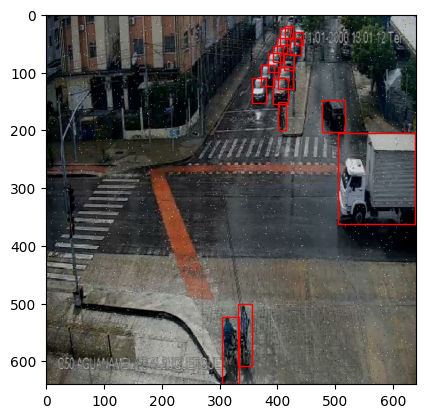

In [10]:
def plot_image_with_bboxes(image, labels):
    fig, ax = plt.subplots(1)
    ax.imshow(image)

    for label in labels:
        class_id, x_center, y_center, width, height = label
        # Convert YOLO format to box coordinates
        x_min = (x_center - width / 2) * image.shape[1]
        y_min = (y_center - height / 2) * image.shape[0]
        box_width = width * image.shape[1]
        box_height = height * image.shape[0]

        # Create a rectangle patch
        rect = patches.Rectangle((x_min, y_min), box_width, box_height, linewidth=1, edgecolor='r', facecolor='none')
        ax.add_patch(rect)

    plt.show()

# Load a batch from the dataset to visualize
for image, labels in train_dataset.take(1):
    plot_image_with_bboxes(image.numpy(), labels.numpy())

# Conversión de anotaciones y almacenamiento
Convierte las etiquetas en formato YOLO a formato Pascal VOC, que usa coordenadas absolutas de bounding boxes:

YOLO: [class_id, x_center, y_center, width, height]

Pascal VOC: [x1, y1, x2, y2]

Convierte las etiquetas para cada conjunto de datos y las guarda en archivos CSV.

In [11]:
def convert_yolo_to_pascal_voc(directory):
    """
    Convert YOLO formatted label files to Pascal VOC format (bounding box coordinates)
    for all images in the specified directory.

    :param directory: The directory containing 'labels' and 'images' subfolders.
    :return: DataFrame containing image file names and bounding box coordinates.
    """
    # Define paths for labels and images
    labels_dir = Path(directory) / 'labels'
    images_dir = Path(directory) / 'images'

    data = []

    # Iterate through each label file
    for label_file in labels_dir.glob('*.txt'):
        image_file = label_file.stem + '.jpg'
        image_path = images_dir / image_file

        # Check if the corresponding image exists
        if not image_path.exists():
            continue  # Skip if image is not found

        # Open image to get its dimensions
        with Image.open(image_path) as img:
            img_width, img_height = img.size

        # Read the label file
        with open(label_file, 'r') as f:
            for line in f:
                parts = line.strip().split()
                class_id = int(parts[0])
                center_x, center_y = float(parts[1]), float(parts[2])
                bbox_width, bbox_height = float(parts[3]), float(parts[4])

                # Convert normalized coordinates to absolute pixel coordinates
                x1 = (center_x - bbox_width / 2) * img_width
                y1 = (center_y - bbox_height / 2) * img_height
                x2 = (center_x + bbox_width / 2) * img_width
                y2 = (center_y + bbox_height / 2) * img_height

                # Append the data for this label
                data.append([image_file, x1, y1, x2, y2, class_id])

    # Create a DataFrame from the collected data
    return pd.DataFrame(data, columns=['name_image', 'x1', 'y1', 'x2', 'y2', 'class'])

In [12]:
# Convertir las anotaciones de YOLO a formato Pascal VOC y guardarlas como un archivo CSV

# Llamar a la función de conversión para las anotaciones de entrenamiento
train_annotations = convert_yolo_to_pascal_voc('/content/traffic-detection-project/train')
test_annotations = convert_yolo_to_pascal_voc('/content/traffic-detection-project/test')
valid_annotations = convert_yolo_to_pascal_voc('/content/traffic-detection-project/valid')

# Guardar las anotaciones convertidas en un archivo CSV
train_annotations.to_csv('/content/traffic-detection-project/train/train_annotations.csv', index=False)
test_annotations.to_csv('/content/traffic-detection-project/test/test_annotations.csv', index=False)
valid_annotations.to_csv('/content/traffic-detection-project/valid/valid_annotations.csv', index=False)

# Exploración de datos
Muestra la distribución de datos entre los conjuntos de entrenamiento, validación y prueba mediante un diagrama de torta:

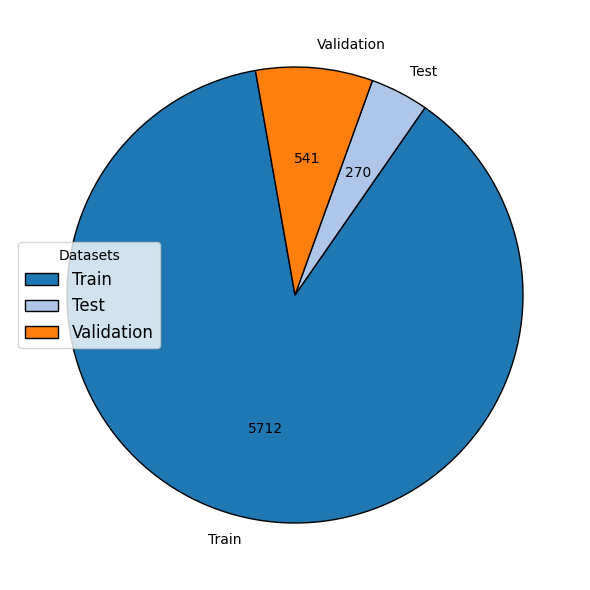

In [13]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

def plot_image_distribution(*csv_files):
    """
    This function takes one or more CSV file paths, each containing image annotations for different datasets
    (train, test, validation) and plots a pie chart showing the distribution of images across the datasets.

    :param csv_files: CSV files containing annotations for different datasets.
    """
    # Prepare labels and sizes for the pie chart
    dataset_names = ['Train', 'Test', 'Validation']
    sizes = []

    for csv_file in csv_files:
        try:
            # Read the CSV
            df = pd.read_csv(csv_file)
            # Calculate the number of unique images
            sizes.append(df['name_image'].nunique())
        except FileNotFoundError:
            print(f"Warning: {csv_file} not found.")
            sizes.append(0)

    # Define a color palette using matplotlib's 'tab20' colormap (more colors for future scalability)
    num_colors = len(sizes)
    colors = plt.cm.tab20.colors[:num_colors]  # Take as many colors as there are datasets

    # Function to format the actual count on each pie slice
    def func(pct, allvalues):
        absolute = int(pct / 100. * sum(allvalues))
        return f"{absolute}"

    # Plotting pie chart
    fig, ax = plt.subplots(figsize=(6, 6))
    wedges, texts, autotexts = ax.pie(sizes, labels=dataset_names[:len(sizes)], colors=colors, autopct=lambda pct: func(pct, sizes),
                                      startangle=100, wedgeprops={'edgecolor': 'black', 'linewidth': 1})

    # Add a legend
    ax.legend(wedges, dataset_names[:len(sizes)], title="Datasets", loc="center left", fontsize=12)

    # Show plot
    plt.tight_layout()
    plt.show()

# Example usage with file paths
train_csv = '/content/traffic-detection-project/train/train_annotations.csv'
test_csv = '/content/traffic-detection-project/test/test_annotations.csv'
validation_csv = '/content/traffic-detection-project/valid/valid_annotations.csv'

plot_image_distribution(train_csv, test_csv, validation_csv)

# Conclusión
Se identificaron imágenes correctamente anotadas mediante las visualizaciones, y fueron exitosas las conversiones de coordenadas de YOLO a Pascal VOC; así mismo el gráfico de torta mostró la representación del conjunto de datos.

Inicialmente se puede evidenciar la correcta delimitación de los objetos en las imágenes anotadas, de acuerdo a su tamaño y forma, mostrando correcta identificación de objetos. Respecto al gráfico de torta, se puede evidenciar que los datos del train representan el 87%, los de validación el 8% y de test el 5%. Aunque los tamaños de los conjuntos son diferentes, la mayor parte de los datos se destina correctamente al entrenamiento (lo cual es ideal porque aquí el modelo aprende); mientras que los conjuntos de validación y prueba tienen un número menor de muestras, pero suficiente para ajustar y evaluar el modelo.

El conjunto de validación es lo suficientemente grande como para ajustar hiper parámetros y verificar que el modelo no esté sobre ajustado; así mismo, el conjunto de prueba tiene un tamaño adecuado para evaluar la capacidad del modelo de generalizar.